In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
# Importing necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from PIL import Image

In [3]:
labels = open('./coco.names').read().strip().split('\n')  # list of names classes
print(labels)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [4]:
weights_path = './yolov3.weights'
configuration_path = './yolov3.cfg'

# Setting minimum probability to eliminate weak predictions
probability_minimum = 0.5
# Setting minimum probability to eliminate weak predictions
probability_minimum = 0.5

# Setting threshold for non maximum suppression
threshold = 0.3

network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)

# Getting names of all layers
layers_names_all = network.getLayerNames()  # list of layers' names
print(layers_names_all)

('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37', 'bn_37', 'leaky_

In [5]:
layers_names_output = [layers_names_all[i - 1] for i in network.getUnconnectedOutLayers()]  # list of layers' names

# Check point
print(layers_names_output)  # ['yolo_82', 'yolo_94', 'yolo_106']

['yolo_82', 'yolo_94', 'yolo_106']


In [6]:
image_input = cv2.imread('./images/de11.png')
image_for_crop = Image.open('./images/de11.png')
#image_for_crop = image_input
image_for_crop
# Getting image shape
image_input_shape = image_input.shape

# Check point
print(image_input_shape)

(648, 1152, 3)


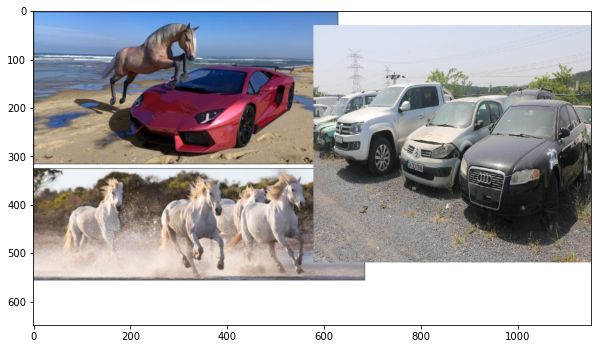

In [7]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
blob = cv2.dnn.blobFromImage(image_input, 1 / 255.0, (416, 416), swapRB=True, crop=False)

# Check point
print(image_input.shape)  
print(blob.shape) 

(648, 1152, 3)
(1, 3, 416, 416)


(416, 416, 3)


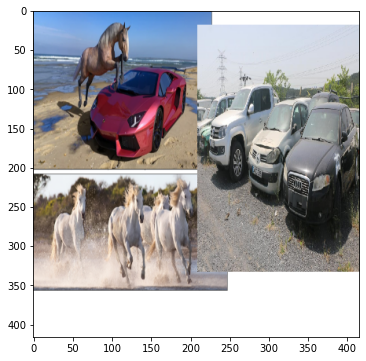

In [9]:
blob_to_show = blob[0, :, :, :].transpose(1, 2, 0)
print(blob_to_show.shape)  # (416, 416, 3)

# Showing 'blob_to_show'
%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 6.0)
plt.imshow(blob_to_show)
plt.show()

In [10]:
network.setInput(blob)  # setting blob as input to the network
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()

# Showing spent time for forward pass
print('YOLO v3 took {:.5f} seconds'.format(end - start))

YOLO v3 took 0.62714 seconds


In [11]:
print(type(output_from_network))  # <class 'list'>
print(type(output_from_network[0]))  # <class 'numpy.ndarray'>

<class 'tuple'>
<class 'numpy.ndarray'>


In [12]:
np.random.seed(42)
# randint(low, high=None, size=None, dtype='l')
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

# Check point
print(colours.shape)  
print(colours[0])  

(80, 3)
[102 220 225]


In [13]:
# Preparing lists for detected bounding boxes, obtained confidences and class's number
bounding_boxes = []
confidences = []
class_numbers = []

# Getting spacial dimension of input image
h, w = image_input_shape[:2]  # Slicing from tuple only first two elements

# Check point
print(h, w)  

for result in output_from_network:
    # Going through all detections from current output layer
    for detection in result:
        # Getting class for current object
        scores = detection[5:]
        class_current = np.argmax(scores)

        # Getting confidence (probability) for current object
        confidence_current = scores[class_current]

        # Eliminating weak predictions by minimum probability
        if confidence_current > probability_minimum:
            # Scaling bounding box coordinates to the initial image size
            # YOLO data format keeps center of detected box and its width and height
            # That is why we can just elementwise multiply them to the width and height of the image
            box_current = detection[0:4] * np.array([w, h, w, h])

            # From current box with YOLO format getting top left corner coordinates
            # that are x_min and y_min
            x_center, y_center, box_width, box_height = box_current.astype('int')
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            # Adding results into prepared lists
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)

# It is needed to make sure the data type of the boxes is 'int'
# and the type of the confidences is 'float'
# https://github.com/opencv/opencv/issues/12789
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

648 1152


In [14]:
our_need_class = ['car','bus','truck','motorbike','horse'] # At this list wa add only class, what we need. If you want cut after all objects, remove this list
not_ok = ['car','bus']
list_box = []
coordinates_need_object = []
class_object = []
classlar = []
confidenceler = []
# Checking if there is at least one detected object
if len(results) > 0:
    # Going through indexes of results
    for i in results.flatten():
        # Getting current bounding box coordinates
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

        # Preparing colour for current bounding box
        colour_box_current = [int(j) for j in colours[class_numbers[i]]]

        # Drawing bounding box on the original image
        cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height),
                      colour_box_current, 5)

        # Preparing text with label and confidence for current bounding box
        text_box_current = '{}:{:.4f}'.format(labels[int(class_numbers[i])], confidences[i])
        confidenceler.append('{:.4f}'.format(confidences[i]))
        classlar.append('{}'.format(labels[int(class_numbers[i])]))
        # Add in our list coordinate boxes and class with probability
        if labels[int(class_numbers[i])] in our_need_class:
            
            coordinates_need_object.append([x_min, y_min,x_min + box_width, y_min + box_height])
            
            # Add in our list name and probability class            
            class_object.append(text_box_current)
        else:
            pass

        # Putting text with label and confidence on the original image
        cv2.putText(image_input, text_box_current, (x_min, y_min - 7), cv2.FONT_HERSHEY_SIMPLEX,
                    1.5, colour_box_current, 5)
        
classlar

['car', 'horse', 'horse', 'horse', 'horse', 'car', 'car', 'car']

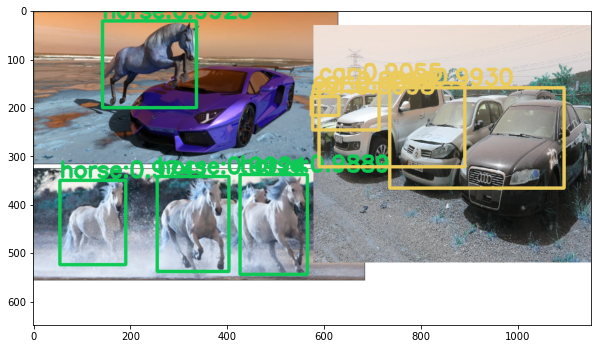

(648, 1152, 3)


In [15]:
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.imshow(image_input)
plt.show()

print(image_input.shape)

In [16]:
data = []
path_to_cr_data = './images/cropped'


### QQ

#### Database, datatime 


In [17]:
import datetime
def time():
    x = datetime.datetime.now()
    return x

classlar

['car', 'horse', 'horse', 'horse', 'horse', 'car', 'car', 'car']

In [18]:
def pltnedir(image):
    plt.imshow(image)
    

#  Main Code

At this picture we have : car:0.9930 
This has coordinates : [736, 158, 1096, 365]


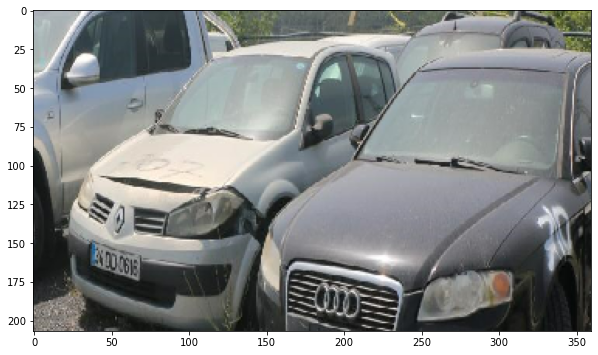

At this picture we have : horse:0.9925 
This has coordinates : [143, 20, 337, 199]


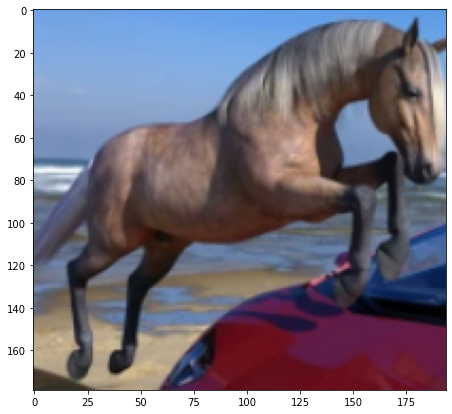

At this picture we have : horse:0.9924 
This has coordinates : [256, 341, 404, 537]


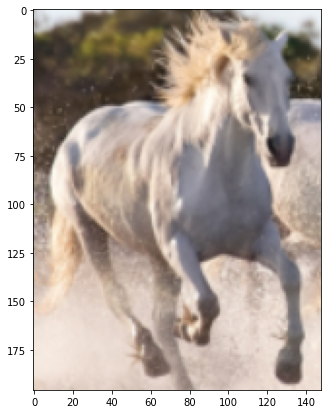

At this picture we have : horse:0.9889 
This has coordinates : [427, 337, 566, 543]


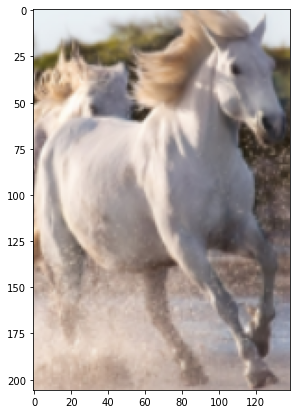

At this picture we have : horse:0.9741 
This has coordinates : [55, 349, 191, 523]


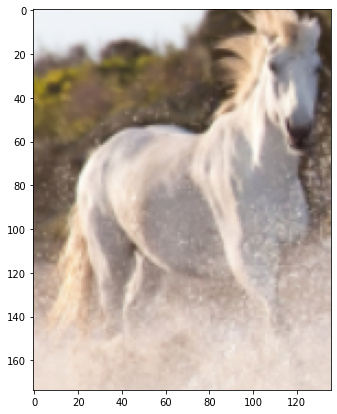

At this picture we have : car:0.9055 
This has coordinates : [590, 148, 891, 321]


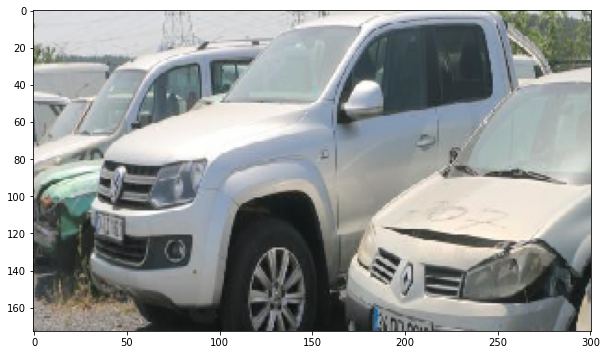

At this picture we have : car:0.8068 
This has coordinates : [577, 165, 714, 245]


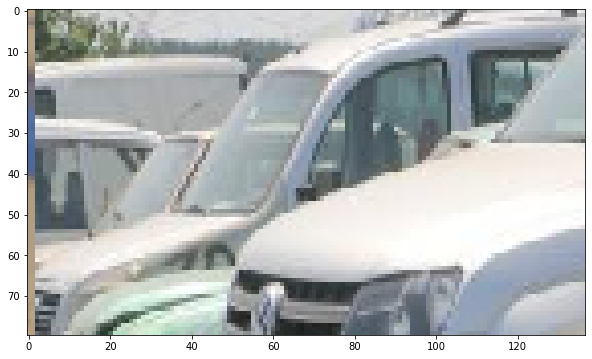

At this picture we have : car:0.6098 
This has coordinates : [574, 176, 631, 215]


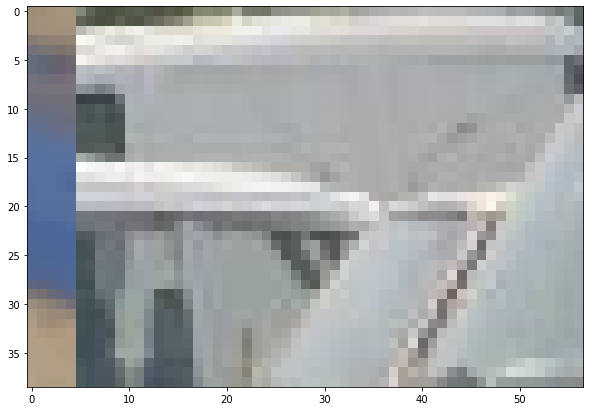

In [19]:
# create a cycle in which we cut out all objects by their coordinates
list_names_cut_objects = []
for i in range(len(class_object)):
    name_cut_obj = f'Cut_object_{class_object[i]}.jpg'
    #name_cut_obj = f'{class_object[i]}.jpg'
    list_names_cut_objects.append(name_cut_obj)
    im_crop = image_for_crop.crop((coordinates_need_object[i]))
    print(f'At this picture we have : {class_object[i]} \nThis has coordinates : {coordinates_need_object[i]}')
    
    #im_crop.save(f'./images/{name_cut_obj}', quality=100)
    #cut_image = Image.open(f'./images/{name_cut_obj}')
    cut_image = im_crop
    file_path = (f"./images/cropped/")
    
    
    #Pandas database
    #our_need_class = ['car','bus','truck','motorbike','horse']  
    if labels[int(class_numbers[i])] in our_need_class:
        Okey_Controller = 'OK'
        if classlar[i] in not_ok:
            Okey_Controller = 'Not Ok'
        
        plt.imshow(cut_image)        
        new_file_path = (file_path + f'{classlar[i]}/{coordinates_need_object[i]}')
        plt.savefig(new_file_path)
        
        data.append((classlar[i], #Type
                     confidenceler[i], #Connfi
                     coordinates_need_object[i], #coordinates
                     new_file_path, #filepath
                     {Okey_Controller} #Type
                     ,time())) # time
        
    plt.imshow(cut_image)
    plt.show()

## database things

In [20]:
import pandas as pd
data = pd.DataFrame(data, columns = ['Type','Confiduence','coordinates','filepath','Type','time'])
data

,Type,Confiduence,coordinates,filepath,Type,time
0,car,0.9930,"[736, 158, 1096, 365]","./images/cropped/car/[736, 158, 1096, 365]",{Not Ok},2022-06-21 02:28:58.821751
1,horse,0.9925,"[143, 20, 337, 199]","./images/cropped/horse/[143, 20, 337, 199]",{OK},2022-06-21 02:28:59.118753
2,horse,0.9924,"[256, 341, 404, 537]","./images/cropped/horse/[256, 341, 404, 537]",{OK},2022-06-21 02:28:59.405526
3,horse,0.9889,"[427, 337, 566, 543]","./images/cropped/horse/[427, 337, 566, 543]",{OK},2022-06-21 02:28:59.687096
4,horse,0.9741,"[55, 349, 191, 523]","./images/cropped/horse/[55, 349, 191, 523]",{OK},2022-06-21 02:28:59.963173
5,car,0.9055,"[590, 148, 891, 321]","./images/cropped/car/[590, 148, 891, 321]",{Not Ok},2022-06-21 02:29:00.246225
6,car,0.8068,"[577, 165, 714, 245]","./images/cropped/car/[577, 165, 714, 245]",{Not Ok},2022-06-21 02:29:00.474463
7,car,0.6098,"[574, 176, 631, 215]","./images/cropped/car/[574, 176, 631, 215]",{Not Ok},2022-06-21 02:29:00.637918


In [22]:
list_names_cut_objects

['Cut_object_car:0.9930.jpg',
 'Cut_object_horse:0.9925.jpg',
 'Cut_object_horse:0.9924.jpg',
 'Cut_object_horse:0.9889.jpg',
 'Cut_object_horse:0.9741.jpg',
 'Cut_object_car:0.9055.jpg',
 'Cut_object_car:0.8068.jpg',
 'Cut_object_car:0.6098.jpg']